In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense

# Function to build the autoencoder model
def build_autoencoder(input_dim):
    autoencoder = Sequential()
    autoencoder.add(Dense(14, input_dim=input_dim, activation='relu'))
    autoencoder.add(Dense(7, activation='relu'))
    autoencoder.add(Dense(14, activation='relu'))
    autoencoder.add(Dense(input_dim, activation='sigmoid'))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Placeholder for Sine Cosine Algorithm (SCA)-optimized K-means
# Note: Implement the actual SCA-optimized K-means algorithm or use a placeholder for now
def sca_kmeans_predict(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    cluster_centers = kmeans.cluster_centers_

    distances = np.linalg.norm(X - cluster_centers[cluster_labels], axis=1)
    return np.where(distances > np.percentile(distances, 90), -1, 1)

# Load the data
data_path = '/content/anomaly_detection_results_sca_kmeans.csv'
data = pd.read_csv(data_path)

# Identify and exclude labeled features
labeled_features = ['anomaly_iso', 'anomaly_lof', 'anomaly_autoencoder', 'anomaly_kmeans', 'anomaly_sca_kmeans']
feature_columns = [col for col in data.columns if col not in labeled_features]

# Select only the feature columns
X = data[feature_columns].values

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize predictions array
predictions = np.zeros((X.shape[0], 5), dtype=int)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
predictions[:, 0] = iso_forest.fit_predict(X_scaled)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
predictions[:, 1] = lof.fit_predict(X_scaled)

# Autoencoder
autoencoder = build_autoencoder(X_scaled.shape[1])
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=0)

reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
predictions[:, 2] = np.where(mse > np.percentile(mse, 90), -1, 1)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.predict(X_scaled)
cluster_centers = kmeans.cluster_centers_

distances = np.linalg.norm(X_scaled - cluster_centers[cluster_labels], axis=1)
predictions[:, 3] = np.where(distances > np.percentile(distances, 90), -1, 1)

# SCA-optimized K-means
predictions[:, 4] = sca_kmeans_predict(X_scaled)

# Combine predictions using majority voting
final_predictions = np.apply_along_axis(lambda x: np.bincount(x + 1).argmax() - 1, axis=1, arr=predictions)

# Add the ensemble predictions to the dataframe
data['ensemble_anomaly'] = final_predictions

# Save the result
output_path = '/content/anomaly_detection_results_with_ensemble.csv'
data.to_csv(output_path, index=False)



126/126 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Data shape: (4032, 30)
   Material  FASD_Category  Purchase Requisition    Abn_PR  Purchasing Group  \
0 -1.558452      -0.151494             -0.319710  0.151956          0.729691   
1 -1.558442       0.943173             -0.296415  0.151956          0.729691   
2 -1.558426      -1.246161              2.812394  0.151956          0.729691   
3 -1.558404      -2.340829              0.022793  0.151956          0.729691   
4 -1.558402      -0.151494             -0.346378  0.151956          0.729691   

   Plant  Quantity Requested  Valuation Price  Net Price on PR  Goods Receipt  \
0      0           -0.121424        -0.146238        -0.172507              0   
1      0           -0.121424        -0.208621        -0.193226              0   
2      0           -0.121424        -0.044266        -0.138639              0   
3      0           -0.121424         0.073984        -0.099365              0   
4      0           -0.121424         0.030993        -0.113643              0   

   ...  L

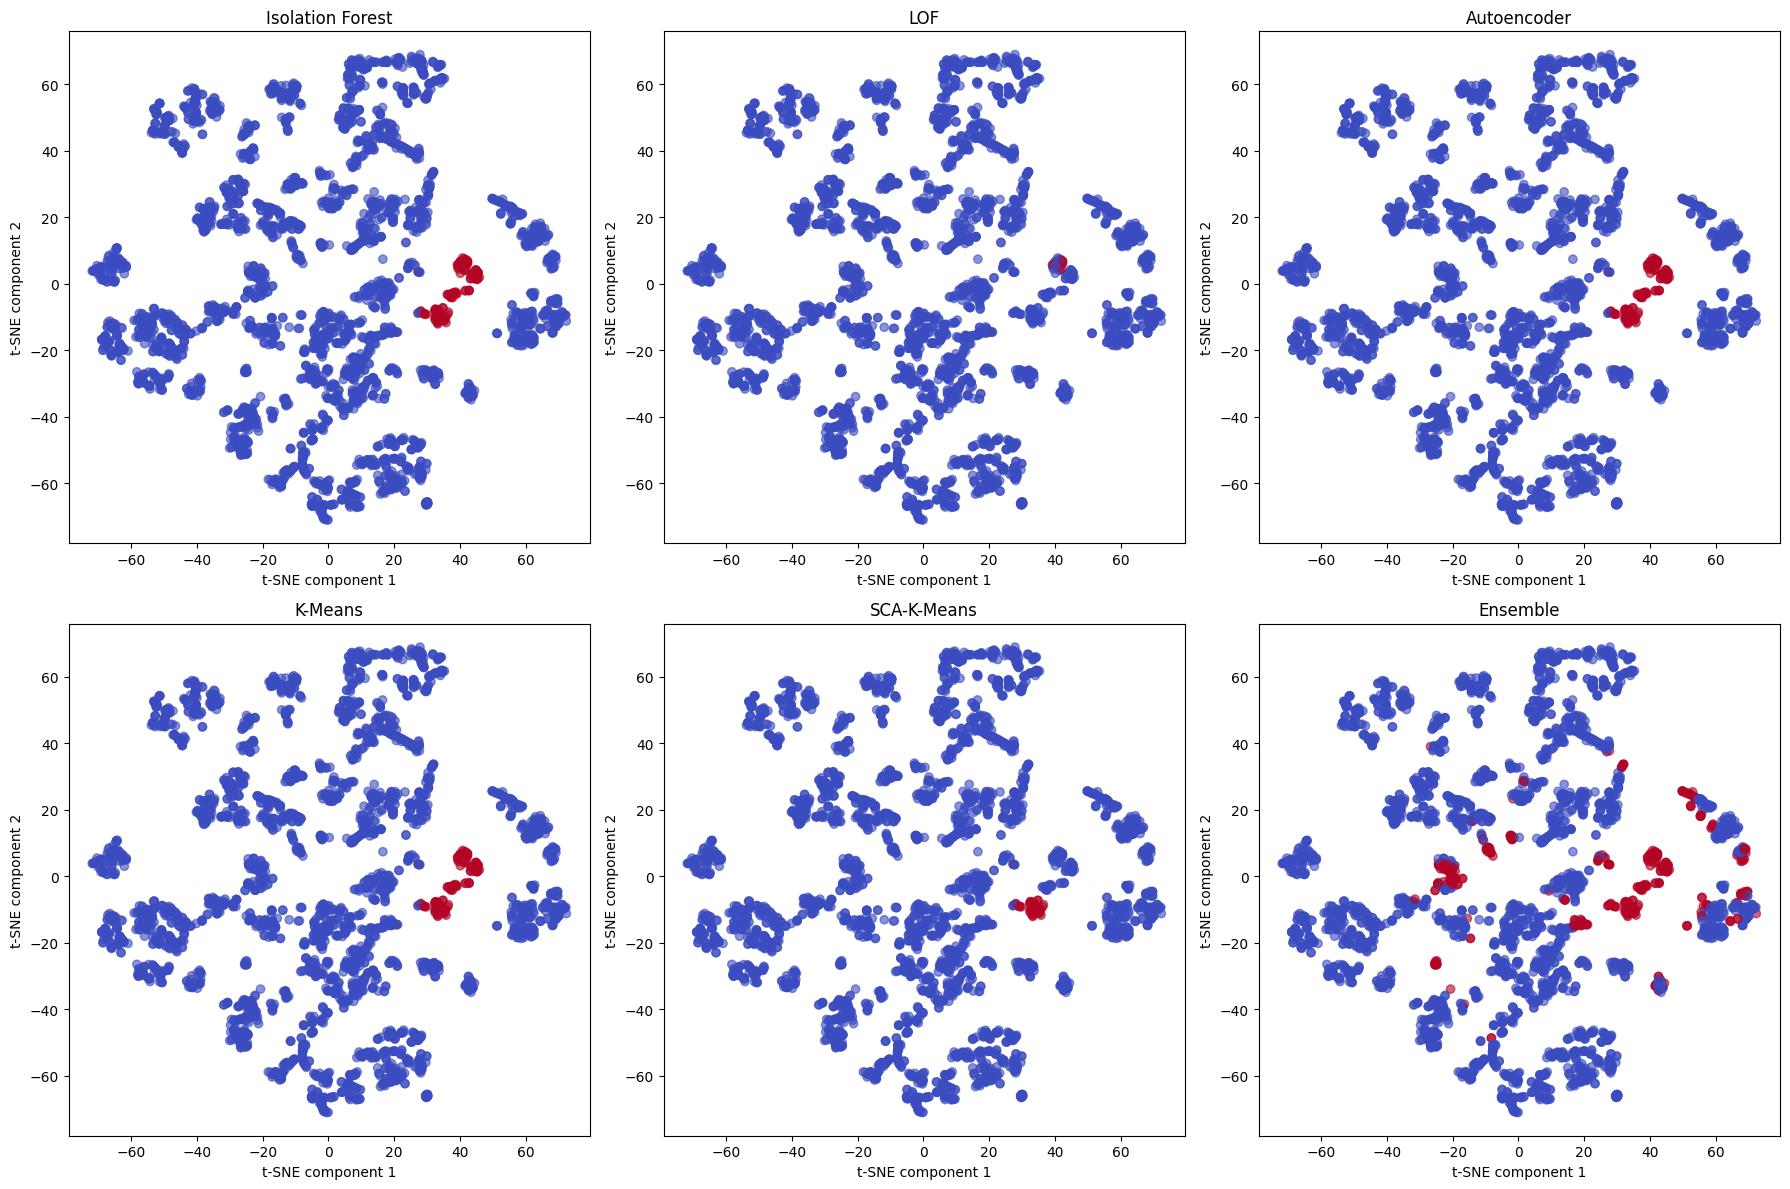

{'Isolation Forest': 140, 'LOF': 11, 'Autoencoder': 140, 'K-Means': 140, 'SCA-K-Means': 49, 'Ensemble': 399}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load the data
data_path = '/content/anomaly_detection_results_with_ensemble.csv'
data = pd.read_csv(data_path)

# Verify the data is loaded correctly
print(f"Data shape: {data.shape}")
print(data.head())

# Identify and exclude labeled features
labeled_features = ['anomaly_iso', 'anomaly_lof', 'anomaly_autoencoder', 'anomaly_kmeans', 'anomaly_sca_kmeans', 'ensemble_anomaly']
feature_columns = [col for col in data.columns if col not in labeled_features]

# Select only the feature columns for t-SNE visualization
X = data[feature_columns].values

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])

# Add anomaly labels for each model
tsne_df['anomaly_iso'] = data['anomaly_iso'].apply(lambda x: 1 if x == 'anomaly' else 0)
tsne_df['anomaly_lof'] = data['anomaly_lof'].apply(lambda x: 1 if x == 'anomaly' else 0)
tsne_df['anomaly_autoencoder'] = data['anomaly_autoencoder'].apply(lambda x: 1 if x == 'anomaly' else 0)
tsne_df['anomaly_kmeans'] = data['anomaly_kmeans'].apply(lambda x: 1 if x == 'anomaly' else 0)
tsne_df['anomaly_sca_kmeans'] = data['anomaly_sca_kmeans'].apply(lambda x: 1 if x == 'anomaly' else 0)
tsne_df['ensemble_anomaly'] = data['ensemble_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Plot the t-SNE results for each model and the ensemble
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Isolation Forest
axs[0, 0].scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=tsne_df['anomaly_iso'], cmap='coolwarm', alpha=0.6)
axs[0, 0].set_title('Isolation Forest')

# LOF
axs[0, 1].scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=tsne_df['anomaly_lof'], cmap='coolwarm', alpha=0.6)
axs[0, 1].set_title('LOF')

# Autoencoder
axs[0, 2].scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=tsne_df['anomaly_autoencoder'], cmap='coolwarm', alpha=0.6)
axs[0, 2].set_title('Autoencoder')

# K-Means
axs[1, 0].scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=tsne_df['anomaly_kmeans'], cmap='coolwarm', alpha=0.6)
axs[1, 0].set_title('K-Means')

# SCA-K-Means
axs[1, 1].scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=tsne_df['anomaly_sca_kmeans'], cmap='coolwarm', alpha=0.6)
axs[1, 1].set_title('SCA-K-Means')

# Ensemble
axs[1, 2].scatter(tsne_df['tsne_1'], tsne_df['tsne_2'], c=tsne_df['ensemble_anomaly'], cmap='coolwarm', alpha=0.6)
axs[1, 2].set_title('Ensemble')

for ax in axs.flat:
    ax.set(xlabel='t-SNE component 1', ylabel='t-SNE component 2')

plt.tight_layout()
plt.show()

# Count the number of anomalies in each model
anomaly_counts = {
    'Isolation Forest': tsne_df['anomaly_iso'].sum(),
    'LOF': tsne_df['anomaly_lof'].sum(),
    'Autoencoder': tsne_df['anomaly_autoencoder'].sum(),
    'K-Means': tsne_df['anomaly_kmeans'].sum(),
    'SCA-K-Means': tsne_df['anomaly_sca_kmeans'].sum(),
    'Ensemble': tsne_df['ensemble_anomaly'].sum()
}

print(anomaly_counts)
